In [2]:
pip install yfinance

# Import



In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Load Dataset

In [3]:
import yfinance as yf
from datetime import date, timedelta, datetime

end_date = date.today().strftime("%Y-%m-%d")
start_date = '1990-01-01'

df = yf.download('AAPL', start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.262722,183198400
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264485,207995200
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265367,221513600
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266249,123312000
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268012,101572800
...,...,...,...,...,...,...
2024-07-08,227.089996,227.850006,223.250000,227.820007,227.820007,59085900
2024-07-09,227.929993,229.399994,226.369995,228.679993,228.679993,48076100
2024-07-10,229.300003,233.080002,229.250000,232.979996,232.979996,62627700


# Data Preprocessing

**Plot Data**

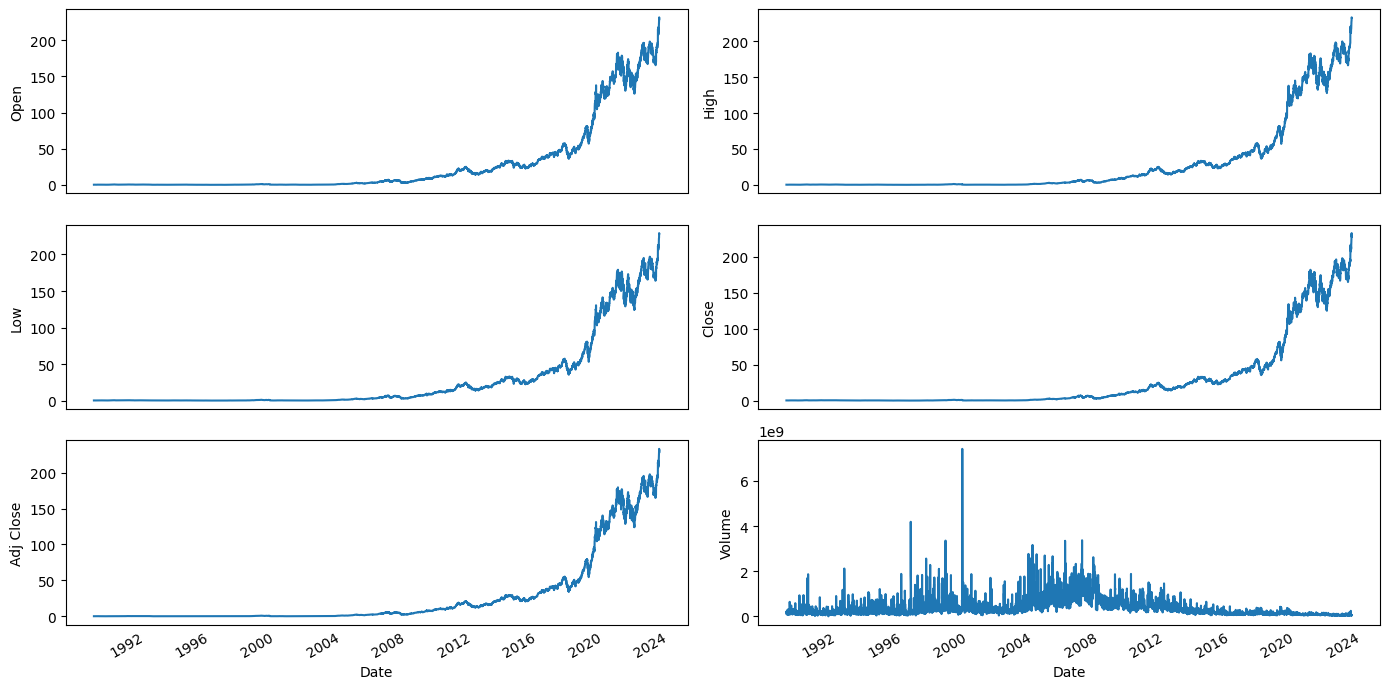

In [5]:
def data_plot(df):
	df_plot = df.copy()

	ncols = 2
	nrows = int(round(df_plot.shape[1] / ncols, 0))

	fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
						sharex=True, figsize=(14, 7))
	for i, ax in enumerate(fig.axes):
		sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
		ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
		ax.xaxis.set_major_locator(mdates.AutoDateLocator())
	fig.tight_layout()
	plt.show()

data_plot(df)


**Split the dataset into train and test**

In [7]:
training_data_len = math.ceil(len(df)*0.8)
print(training_data_len)

train_data = df[:training_data_len].iloc[:, :1]
test_data = df[training_data_len:].iloc[:, :1]
print(train_data.shape, test_data.shape)

6959
(6959, 1) (1739, 1)


In [14]:
dataset_train = train_data['Open'].values

# reshape 1D array to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape

(6959, 1)

In [15]:
dataset_test = test_data['Open'].values

# reshape 1D array to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(1739, 1)

**Normalization**

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

scaled_test = scaler.fit_transform(dataset_test)
print(scaled_test[:5])

[[0.00501196]
 [0.00562797]
 [0.00568396]
 [0.00557197]
 [0.00551595]]
[[0.01962692]
 [0.0213414 ]
 [0.0229791 ]
 [0.02116227]
 [0.0177589 ]]


**Transforming data into sequence**

In [21]:
scaled_test.shape

(1739, 1)

In [23]:
# create sequences and labels for training data
sequence_length = 50
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])

X_train, y_train  = np.array(X_train), np.array(y_train)

# convert into pytorch tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)

X_train.shape, y_train.shape


(torch.Size([6909, 50, 1]), torch.Size([6909, 50, 1]))

In [24]:
# create sequences and labels for testing data
sequence_length = 30
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])

X_test, y_test  = np.array(X_test), np.array(y_test)

# convert into pytorch tensors
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

X_test.shape, y_test.shape

(torch.Size([1709, 30, 1]), torch.Size([1709, 30, 1]))

# LSTM Model

In [28]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.linear(out)
    return out

In [29]:
# setw hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


**Define the model**

In [31]:
input_size = 1
num_layers = 2
hidden_size = 32
output_size = 1

model = LSTM(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


**Data Loader for batch training**

In [32]:
batch_size = 16
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# Model Training and Evaluations

In [40]:
num_epochs = 10
train_hist = []
test_hist = []

for epoch in range(num_epochs):
  total_loss = 0.0

  model.train()
  for batch_x, batch_y in train_loader:
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    predictions = model(batch_x)
    loss = loss_fn(predictions, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  average_loss = total_loss / len(train_loader)
  train_hist.append(average_loss)

  # validataion on test data
  model.eval()
  with torch.no_grad():
    total_test_loss = 0.0
    for batch_x_test, batch_y_test in test_loader:
      batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
      predictions_test = model(batch_x_test)
      test_loss = loss_fn(predictions_test, batch_y_test)

      total_test_loss += test_loss.item()

      # calculate the average tests loss and accuracy
    average_test_loss = total_test_loss / len(test_loader)
    test_hist.append(average_test_loss)

  if (epoch+1)%5==0:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')



Epoch [5/10] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [10/10] - Training Loss: 0.0000, Test Loss: 0.0001


**Plotting the Learning Curve**

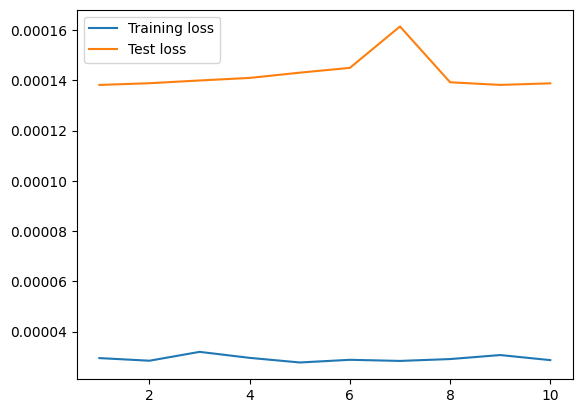

In [41]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


**Forecasting**

In [42]:
num_forecast_steps = 30

sequence_to_plot = X_test.squeeze().cpu().numpy()

historical_data = sequence_to_plot[-1]
print(historical_data.shape)

(30,)


In [44]:
# Initialize a list to store the forecasted values
forecasted_values = []


# use the trained model to forecast future values
with torch.no_grad():
  for _ in range(num_forecast_steps*2):
    historical_data_tensor = torch.as_tensor(historical_data).view(1,-1,1).float().to(device)
    predicted_value = model(historical_data_tensor).cpu().numpy()[0,0]

    forecasted_values.append(predicted_value[0])

    historical_data = np.roll(historical_data, shift=-1)
    historical_data[-1] = predicted_value


last_date = test_data.index[-1]

future_dates = pd.date_range(start=last_date+pd.DateOffset(1), periods=30)

combined_index = test_data.index.append(future_dates)

<ipython-input-44-a4104778e443>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


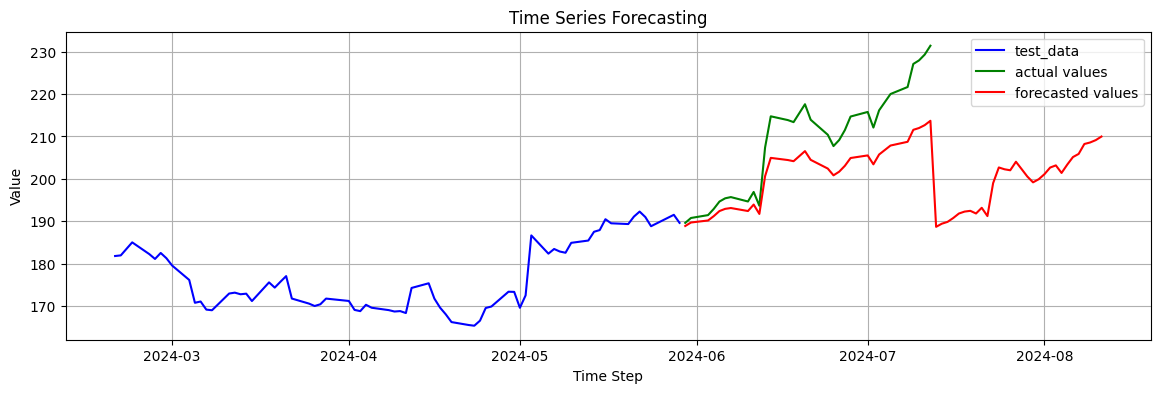

In [45]:
#set the size of the plot
plt.rcParams['figure.figsize'] = [14, 4]


#Test data
plt.plot(test_data.index[-100:-30], test_data.Open[-100:-30], label = "test_data", color = "b")
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()

#the historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green')

#Forecasted Values
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
